#Student Name: Rahul Deshmukh
#ECE 595 Machine Learning II
#Project 3: GAN - Student Code

In [0]:
#Import necessary packages
import numpy as np
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras.models import load_model
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Part 1: Implementing the GAN

Epoch 10000
10000: [Discriminator loss: 0.690543, acc: 0.323242]  [GAN loss: 0.919434, acc: 0.230469]


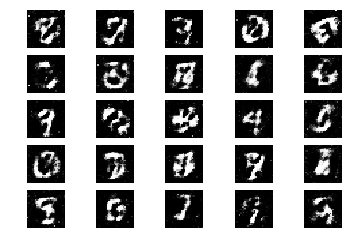

Epoch 20000
20000: [Discriminator loss: 0.579253, acc: 0.390625]  [GAN loss: 1.187496, acc: 0.148438]


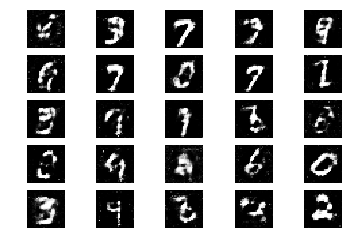

Epoch 30000
30000: [Discriminator loss: 0.574769, acc: 0.414062]  [GAN loss: 1.200303, acc: 0.164062]


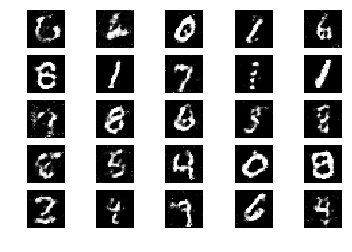

Epoch 40000
40000: [Discriminator loss: 0.604514, acc: 0.423828]  [GAN loss: 1.130691, acc: 0.160156]


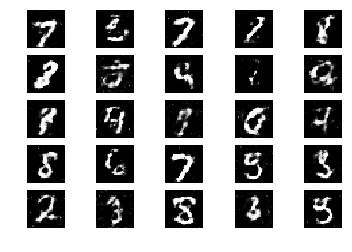

Epoch 50000
50000: [Discriminator loss: 0.599443, acc: 0.397461]  [GAN loss: 1.202461, acc: 0.160156]


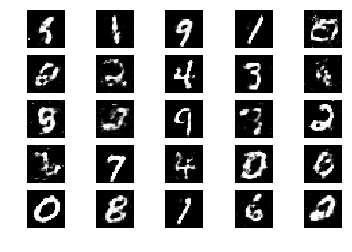

Epoch 60000
60000: [Discriminator loss: 0.596534, acc: 0.405273]  [GAN loss: 1.184103, acc: 0.160156]


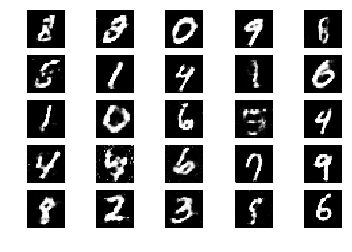

Epoch 70000
70000: [Discriminator loss: 0.609079, acc: 0.393555]  [GAN loss: 1.129238, acc: 0.187500]


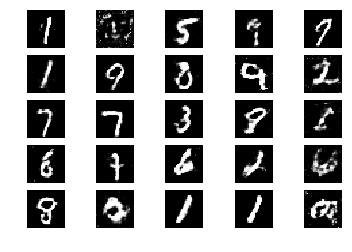

Epoch 80000
80000: [Discriminator loss: 0.607645, acc: 0.396484]  [GAN loss: 1.142349, acc: 0.187500]


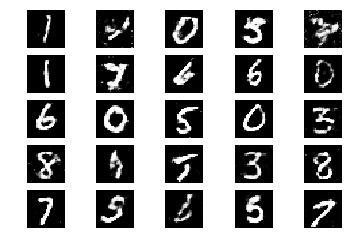

Epoch 90000
90000: [Discriminator loss: 0.609426, acc: 0.401367]  [GAN loss: 1.123774, acc: 0.167969]


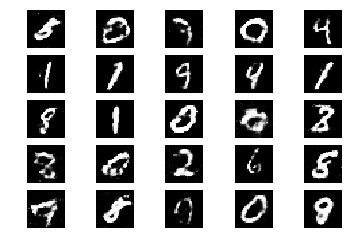

Epoch 100000
100000: [Discriminator loss: 0.603964, acc: 0.398438]  [GAN loss: 1.101250, acc: 0.187500]


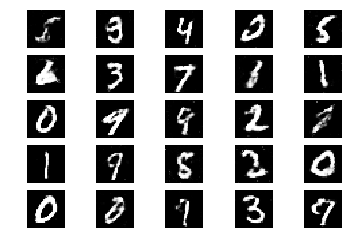

In [0]:
#Load MNIST data and normalize to [-1, 1]
(data_train, _), (data_test, _) = mnist.load_data()
data_train = 2.0*(data_train/255.0) -1.0
data_test = 2.0*(data_test/255.0) -1.0

#reshape data
X_train= data_train.reshape(60000,784)
X_test= data_test.reshape(10000,784)

# The D-dimensional noise vector length
latent_dim = 100
data_dim=784
dropout = 0.4
epsilon = 0.1

# Optimizer for discriminator, which will have a higher learning rate than adversarial model
def dis_optimizer():
    return adam(lr=0.00002,beta_1=0.5,beta_2=0.999)

def gan_optimizer():
  return adam(lr=0.0001,beta_1=0.9,beta_2=0.999)

# Genrerator model
def create_generator():
    generator = Sequential()
    generator.add(Dense(300,input_dim=latent_dim))
    generator.add(LeakyReLU(0.5))
    generator.add(Dense(600))
    generator.add(LeakyReLU(0.5))
    generator.add(Dense(1200))
    generator.add(LeakyReLU(0.5))
    generator.add(Dense(data_dim,activation='tanh'))

    return generator

# Discriminator model
def create_discriminator():
  discriminator = Sequential()
  discriminator.add(Dense(1200 , input_dim=data_dim ) )
  discriminator.add(LeakyReLU( 0.5 ))
  discriminator.add(Dropout(dropout))
  discriminator.add(Dense( 600 ) )
  discriminator.add(LeakyReLU( 0.5 ) )
  discriminator.add(Dropout(dropout))
  discriminator.add(Dense( 300 ) )
  discriminator.add(LeakyReLU( 0.5 ) )

  discriminator.add(Dense( units =1 , activation='sigmoid'))
  
  discriminator.compile(loss='binary_crossentropy',
                        optimizer=dis_optimizer(),
                       metrics=['accuracy'])
  
  return discriminator

# Create adversarial model
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape = (latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs = gan_input, outputs = gan_output)
    gan.compile(loss='binary_crossentropy',
               optimizer=gan_optimizer(),
               metrics = ['accuracy'])
    return gan

# Creating GAN
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator,generator)

# Model and training parameters
#ASSIGN VALUES TO THE FOLLOWING VARIABLES
epochs = 100000
batch_size = 512
sample_interval = 10000

# epochs = 20
# batch_size = 25
# sample_interval = 1

# Array to save training history
training_meta_data = np.zeros([epochs, 4])

# Training the GAN
for e in range(1, epochs+1):

    # Generate random noise as input
    noise = np.random.normal(size=(batch_size,latent_dim))

    # Generate fake MNIST images from generated noise
    fake_images = generator.predict(noise)

    # Get a random set of real MNIST images
    chosen_indices = np.random.choice(np.arange(X_train.shape[0]),size=batch_size)
    real_images = X_train[chosen_indices,:]

    # Concatenate real and fake images into a single array (or batch)
    data_total = np.vstack((real_images,fake_images))

    # Assign training labels (assign high probability, but not 1, to real images)
    labels_real = (1-epsilon)*np.ones(batch_size)
    labels_fake = 0.0*np.ones(batch_size)
    labels_discriminator= np.hstack((labels_real,labels_fake))
    
    # Allow discriminator parameters to be updated
    discriminator.trainable = True

    # Train discriminator on batch of real and fake images. Assign loss and accuracy to variable
    d_loss = discriminator.train_on_batch(data_total,labels_discriminator)
    
    # Train adversarial model and try to fool discriminator (with incorrect label) 
    # by generating a new batch of noise and assign them labels of real data
    noise = np.random.normal(size=(batch_size,latent_dim))
    fake_images = generator.predict(noise)
    data_total = np.vstack((real_images,fake_images))
    
    labels_generator = np.ones(batch_size)

    # Keep discriminator weights constant while training generator
    discriminator.trainable = False

    # Train GAN (without updating discriminator weights) on new batch of fake images. Assign loss and accuracy to variable
    gan_loss = gan.train_on_batch(noise,labels_generator)
    
    # Save training status
    # Discriminator and model loss
    training_meta_data[e-1, 0] = d_loss[0]
    training_meta_data[e-1, 1] = gan_loss[0]

    # Discriminator and model accuracy
    training_meta_data[e-1, 2] = d_loss[1]
    training_meta_data[e-1, 3] = gan_loss[1]


    # If at sample interval, print training status and save samples
    if e % sample_interval == 0:
      
        # Print training status
        print("Epoch %d" %e)
        log_mesg = "%d: [Discriminator loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [GAN loss: %f, acc: %f]" % (log_mesg, gan_loss[0], gan_loss[1])
        print(log_mesg)
        
        # Plot images 
        r, c = 5, 5

        # Create images from the noise (predict the outcome of the noise)
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt].reshape(28, 28)), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        
# save models and weights
discriminator.save_weights('discriminator_wts.h5')
with open('discriminator_arch.json','w') as f:
  f.write(discriminator.to_json())

gan.save_weights('gan_wts.h5')
with open('gan_arch.json','w') as f:
  f.write(gan.to_json())

np.save('training_meta_data',training_meta_data)

!cp training_meta_data.npy /content/gdrive/My\ Drive/ML2/Project-3/
  
!cp discriminator_wts.h5 /content/gdrive/My\ Drive/ML2/Project-3/
!cp discriminator_arch.json /content/gdrive/My\ Drive/ML2/Project-3/
!cp gan_wts.h5 /content/gdrive/My\ Drive/ML2/Project-3/       
!cp gan_arch.json /content/gdrive/My\ Drive/ML2/Project-3/  
        

Text(0.5,0,'Epoch')

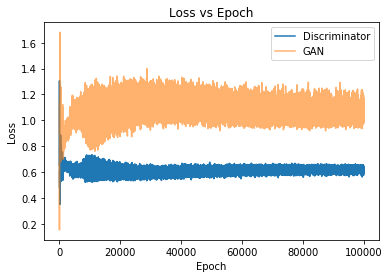

In [0]:
# Plot model loss vs epoch
plt.plot(np.arange(epochs),training_meta_data[:,0])
plt.plot(np.arange(epochs),training_meta_data[:,1],alpha=0.6)
plt.title('Loss vs Epoch')
plt.legend(['Discriminator','GAN'],loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')

Text(0.5,0,'Epoch')

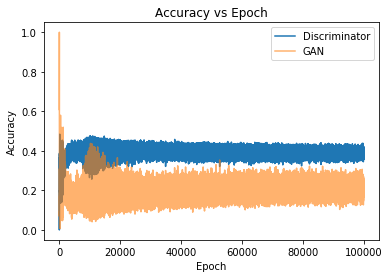

In [0]:
# Plot accuracy vs epoch
plt.plot(np.arange(epochs),training_meta_data[:,2])
plt.plot(np.arange(epochs),training_meta_data[:,3],alpha=0.6)
plt.title('Accuracy vs Epoch')
plt.legend(['Discriminator','GAN'],loc='upper right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

Answer the following questions:



1.   Why does the accuracy of the discriminator remain around 50%? Is this a good trait of the GAN? 

  ANS: As we are giving the discriminator, equal proportions of real and fake data, therefore the discriminator should predict that that 50\% of the data is real. Idle accuracy of the discriminator should be exactly 50\% and an observed accuracy of close to 50\%  is a good trait for GAN.


2.   How could this model be modified to produce cleaner (less noisy) images? 

  ANS: In this exercise we obtained a generator using an pixel-wise MLP framework which would not learn texture/information of the surrounding pixels and thus is prone to noisy images. A Convolutional network for generator and discriminator will produce cleaner images.

#Part 2: Generating samples using trained generator

In [0]:
# Generate ten images from Gaussian noise using the trained generator from Part 1
noise = np.random.normal(size=(10,latent_dim))
generated_images = generator.predict(noise)

# Re-scale generated images to lie in [0, 1]
generated_images = 0.5*(generated_images + 1.0)

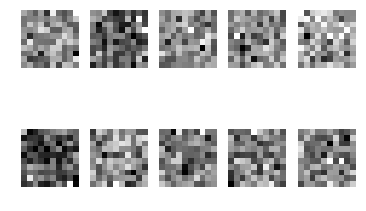

In [0]:
# Visualize generated noise
r, c = 2, 5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((noise[cnt].reshape(10, 10)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()

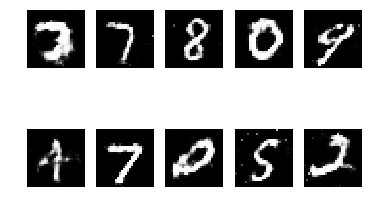

In [0]:
# Visualize generated samples
r, c = 2, 5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((generated_images[cnt].reshape(28, 28)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()

#Part 3: Testing accuracy of generated images on ten samples

In [0]:
# Load mnist classifier and generated images
!cp /content/gdrive/My\ Drive/ML2/Project-3/mnist_classifier.h5 ./
mnist_classifier = load_model('mnist_classifier.h5')

In [0]:
# ASSIGN CLASSES
labels = [3,7,8,0,9,4,7,0,5,2]

# Convert integer labels to one-hot labels 
labels = keras.utils.np_utils.to_categorical(labels, num_classes=10)

# Show classifications
predicted_labels = mnist_classifier.predict(generated_images)
predicted_labels_int = [np.argmax(predicted_labels[row,:]) for row in range(predicted_labels.shape[0])]
print('predicted labels by pre-trained classifier: '+str(predicted_labels_int))


# Evaluate accuracy
score=mnist_classifier.evaluate(generated_images,labels)

print("Accuracy: %0.2f%%"%(score[1]*100))
  

predicted labels by pre-trained classifier: [7, 7, 8, 0, 4, 4, 7, 0, 5, 2]
10/10 [==============================] - 1s 105ms/step
Accuracy: 80.00%


Answer the following question:

1. State the accuracy of the classifier on your ten generated images. Based on
this accuracy, would you say your generator does well in producing images
comparable to those in the MNIST dataset of hand-written digits? Why or
why not?

  ANS: The accuracy of the classifier on the 10 generated images was 80\%. Based on this accuracy one would think that the generator does a good job in producing the images comparable to those in the MNIST dataset, however the sample size of 10 images for evaluation is way too small to give out this judgement. However, the computed generator is able to produce a variety (ie belonging to several classes) of discriminable samples with diverse samples for each class, therefore it is an acceptable generator.
  

2. In this project, we only tested the performance of the pre-trained classifier
on ten samples and used its result to determine the robustness of the generator. How could we better assess the quality of the generated images using
this pre-trained classifier and the saved generator?

  ANS: To assess the quality of the generated images we can use several scores such as Inception Score (IS), Frechet Inception Distance (FID) to quantify how close is the spread of generated data from the spread of real data in a feature space. Source: [Pros and Cons of GAN Evaluation Measures](http://arxiv.org/abs/1802.03446).